# Feature engineering

So far we have only used closing price and relative differences as features, which has limited the performance of the model. In this regard, we have further investigated different metrics and indicators used in the literature to improve the features used in the model.

Based on the work of Patel and Won, we summarize and apply three basic financial indicators: 
- Simple n-day moving average 
- 10-day weighted moving average
- Momentum

Alongside with the full vector of raw information:
- O: Opening price of the day.
- C: Closing price of the day.
- H: Highest price during the day.
- L: Lowest price during the day.

References:
- Jigar Patel, Sahil Shah, Priyank Thakkar, K Kotecha, Predicting stock market index using fusion of machine learning techniques,
Expert Systems with Applications, Volume 42, Issue 4, 2015, Pages 2162-2172, ISSN 0957-4174, https://doi.org/10.1016/j.eswa.2014.10.031.
- Jae Won Lee, "Stock price prediction using reinforcement learning," ISIE 2001. 2001 IEEE International Symposium on Industrial Electronics Proceedings (Cat. No.01TH8570), Pusan, South Korea, 2001, pp. 690-695 vol.1, doi: 10.1109/ISIE.2001.931880.


In [1]:
cd ~/downloads/Pedro-Pineapple

[WinError 2] The system cannot find the file specified: 'C:\\Users\\e-raguirrer/downloads/Pedro-Pineapple'
c:\Users\e-raguirrer\Documents\Repositories\ProyectoIntegrador\Pedro-Pineapple


In [10]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from matplotlib.dates import DayLocator
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size']=16
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['figure.figsize']=16,5.5

In [11]:
data = pd.read_csv('data_sp.csv')
data.columns = data.columns.str.lower()

In [12]:
data.head(10)

,date,open,high,low,close,adj close,volume
0,2017-01-03,225.039993,225.830002,223.880005,225.240005,200.629715,91366500
1,2017-01-04,225.619995,226.750000,225.610001,226.580002,201.823288,78744400
2,2017-01-05,226.270004,226.580002,225.479996,226.399994,201.662872,78379000
3,2017-01-06,226.529999,227.750000,225.899994,227.210007,202.384460,71559900
4,2017-01-09,226.910004,227.070007,226.419998,226.460007,201.716385,46939700
5,2017-01-10,226.479996,227.449997,226.009995,226.460007,201.716385,63771900
6,2017-01-11,226.360001,227.100006,225.589996,227.100006,202.286438,74650000
7,2017-01-12,226.500000,226.750000,224.960007,226.529999,201.778732,72113200
8,2017-01-13,226.729996,227.399994,226.690002,227.050003,202.241882,62717900
9,2017-01-17,226.309998,226.779999,225.800003,226.250000,201.529358,61240800


In [17]:
# Features library.
# Author: @THEFFTKID

import pandas as pd
import numpy as np


def n_rolling_mean(
    x_: pd.Series, n: int
) -> pd.Series:
    """
    Calculated the N day rolling mean.
    """
    return x_.rolling(window=n).mean().fillna(0)


def weighted_n_moving_avg(
    x_: pd.Series, n: int
) -> pd.Series:
    """
    Calculates the N day weighted rolling mean.
    """
    weights = np.arange(1, n + 1)
    wma = x_.rolling(window=n).apply(
        lambda x: np.dot(x, weights) / weights.sum(),
        raw=True
    ).fillna(0)
    return wma


def momentum(
    x_: pd.Series, n: int
) -> pd.Series:
    """
    Calculates the n day momentum.
    """
    hare = np.arange(n, len(x_))
    # Momentum.
    m = [0] * n
    for i in hare:
        m.append(
            x_[i] - x_[i - n]
        )
    return pd.Series(m)


def tendency_removal(
        df_close: pd.Series,
        n: int
) -> pd.Series:
    '''
    Calculate the closing price minus the n day moving
    average to remove the tendency.
    '''
    n_moving_average = df_close.rolling(
        window=n
    ).mean().fillna(0)
    eliminate_tendency = df_close - n_moving_average
    eliminate_tendency.iloc[:n] = 0
    return eliminate_tendency

def volume_perc_rate_of_change(
        df_volume: pd.Series
) -> pd.Series:
    '''
    Calculate the relative rate of change for the volume. 
    '''
    v_proc = df_volume.pct_change().fillna(0) * 100
    return v_proc

def williams_range(
        data: pd.DataFrame,
        days: int = 14,

)-> pd.Series:
    '''
    Calculate the Williams Percent Range, a momentum indicator that 
    measures underbought and oversold. 
    '''
    
    highest_high = data['high'].rolling(window=days).max().fillna(0)
    lowest_low = data['low'].rolling(window=days).min().fillna(0)
    is_equal = highest_high[days::] == lowest_low[days::]
    
    williams_prange = (highest_high - data['close']) / (highest_high - lowest_low)*-100
    williams_prange[:days] = 0

    if is_equal.any() == True:
         williams_prange[days::] = williams_prange[days::].replace([np.inf, -np.inf], -100) #Highest_high == lowest_low

    return williams_prange, highest_high, lowest_low


def stochastic_oscillator(
        data:pd.DataFrame,
        days:int = 14
) -> pd.Series:
    s_o = (data['close']-data['n_lowest_low'])/(data['n_highest_high']-data['n_lowest_low'])*100
    s_o[:days] = 0 
    return s_o

In [21]:
data['n_rolling_mean'] = n_rolling_mean(
    x_=data['close'], n=10
)
# 10-day weighted  rolling mean.
data['weighted_rolling_mean'] = weighted_n_moving_avg(
    x_=data['close'], n=10
)
# Momentum.
data['momentum'] = momentum(x_=data['close'], n=10)

# Removal of tendency to closing price
data['nday_tendency_removal'] = tendency_removal(
    df_close=data['close'], n=10
)
# Volume rate of change
data['volume_roc'] = volume_perc_rate_of_change(
    df_volume = data['volume']
)
# Williams R%
data['williams_p_range'],data['n_highest_high'],data['n_lowest_low'] = williams_range(data=data)

data['stochastic_oscillator'] = stochastic_oscillator(data=data)

In [22]:
data

,date,open,high,low,close,adj close,volume,n_rolling_mean,weighted_rolling_mean,momentum,nday_tendency_removal,volume_roc,williams_p_range,n_highest_high,n_lowest_low,stochastic_oscillator
0,2017-01-03,225.039993,225.830002,223.880005,225.240005,200.629715,91366500,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,2017-01-04,225.619995,226.750000,225.610001,226.580002,201.823288,78744400,0.000000,0.000000,0.000000,0.000000,-13.814801,0.000000,0.000000,0.000000,0.000000
2,2017-01-05,226.270004,226.580002,225.479996,226.399994,201.662872,78379000,0.000000,0.000000,0.000000,0.000000,-0.464033,0.000000,0.000000,0.000000,0.000000
3,2017-01-06,226.529999,227.750000,225.899994,227.210007,202.384460,71559900,0.000000,0.000000,0.000000,0.000000,-8.700162,0.000000,0.000000,0.000000,0.000000
4,2017-01-09,226.910004,227.070007,226.419998,226.460007,201.716385,46939700,0.000000,0.000000,0.000000,0.000000,-34.405023,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1706,2023-10-13,435.209991,436.450012,429.880005,431.500000,431.500000,95143100,429.591003,431.530732,4.019989,1.908997,17.237432,-34.032605,437.339996,420.179993,65.967395
1707,2023-10-16,433.820007,437.140015,433.570007,436.040009,436.040009,75433200,430.464005,432.703278,8.730011,5.576004,-20.716058,-7.575685,437.339996,420.179993,92.424315
1708,2023-10-17,432.809998,438.140015,432.450012,436.019989,436.019989,75324700,431.907004,433.713457,14.429993,4.112985,-0.143836,-11.804137,438.140015,420.179993,88.195863
1709,2023-10-18,434.190002,435.179993,429.089996,430.209991,430.209991,93559800,432.462003,433.404909,5.549988,-2.252011,24.208659,-44.153750,438.140015,420.179993,55.846250


## EDA on features

In [29]:
x_spacing = 60
x_rotation = 45

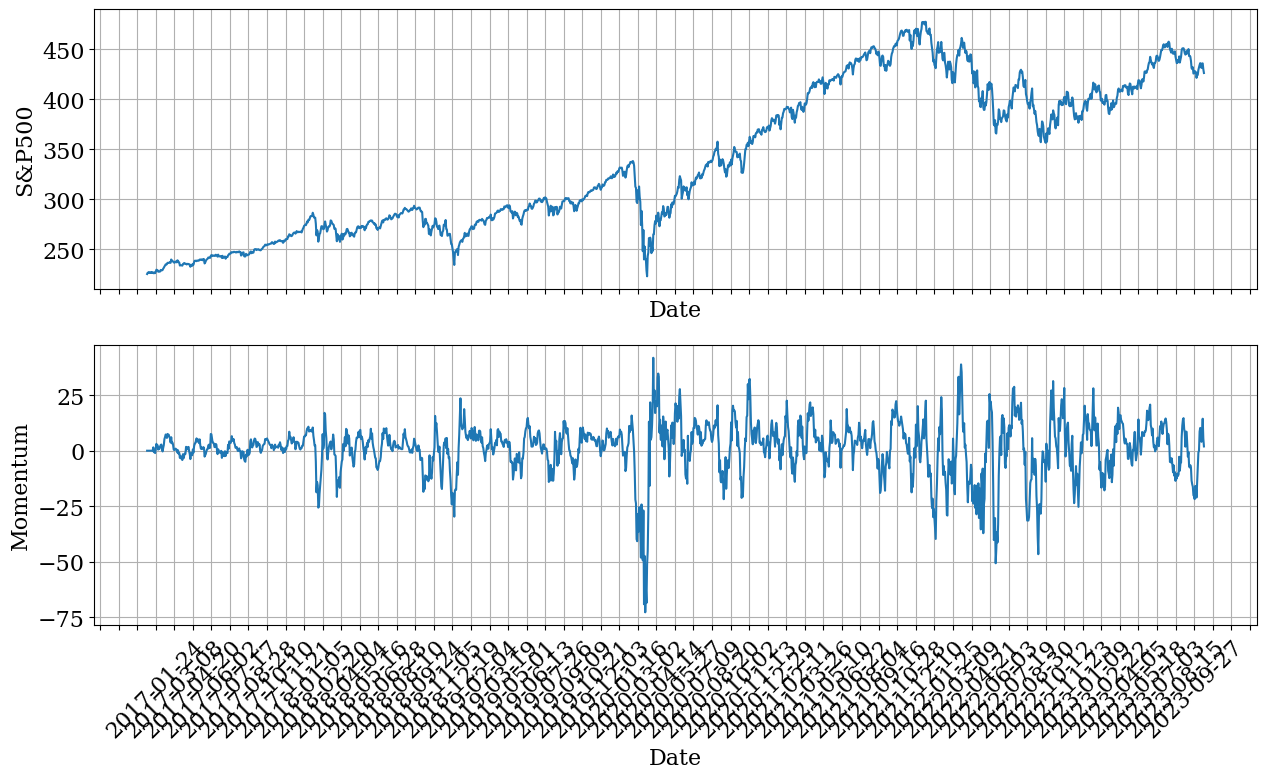

In [24]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True,  figsize=(15, 8))

ax1.plot(data['date'], data['close'])
ax1.set_xlabel('Date')
ax1.set_ylabel('S&P500')
ax1.xaxis.set_major_locator(DayLocator(interval=x_spacing))
ax1.tick_params(axis='x', rotation=x_rotation)
ax1.grid()


ax2.plot(data['date'], data['momentum'])
ax2.set_xlabel('Date')
ax2.set_ylabel('Momentum')
ax2.tick_params(axis='x', rotation=x_rotation)
ax2.xaxis.set_major_locator(DayLocator(interval=x_spacing))
ax2.grid()


In [25]:
# MCT.
data['momentum'].describe()

count    1711.000000
mean        1.204717
std        11.766166
min       -72.859985
25%        -2.915009
50%         2.520004
75%         7.394989
max        41.909988
Name: momentum, dtype: float64

In [27]:
# MCT
data['weighted_rolling_mean'].describe()

count    1711.000000
mean      337.282693
std        77.365252
min         0.000000
25%       273.275269
50%       322.297267
75%       410.315274
max       475.930907
Name: weighted_rolling_mean, dtype: float64

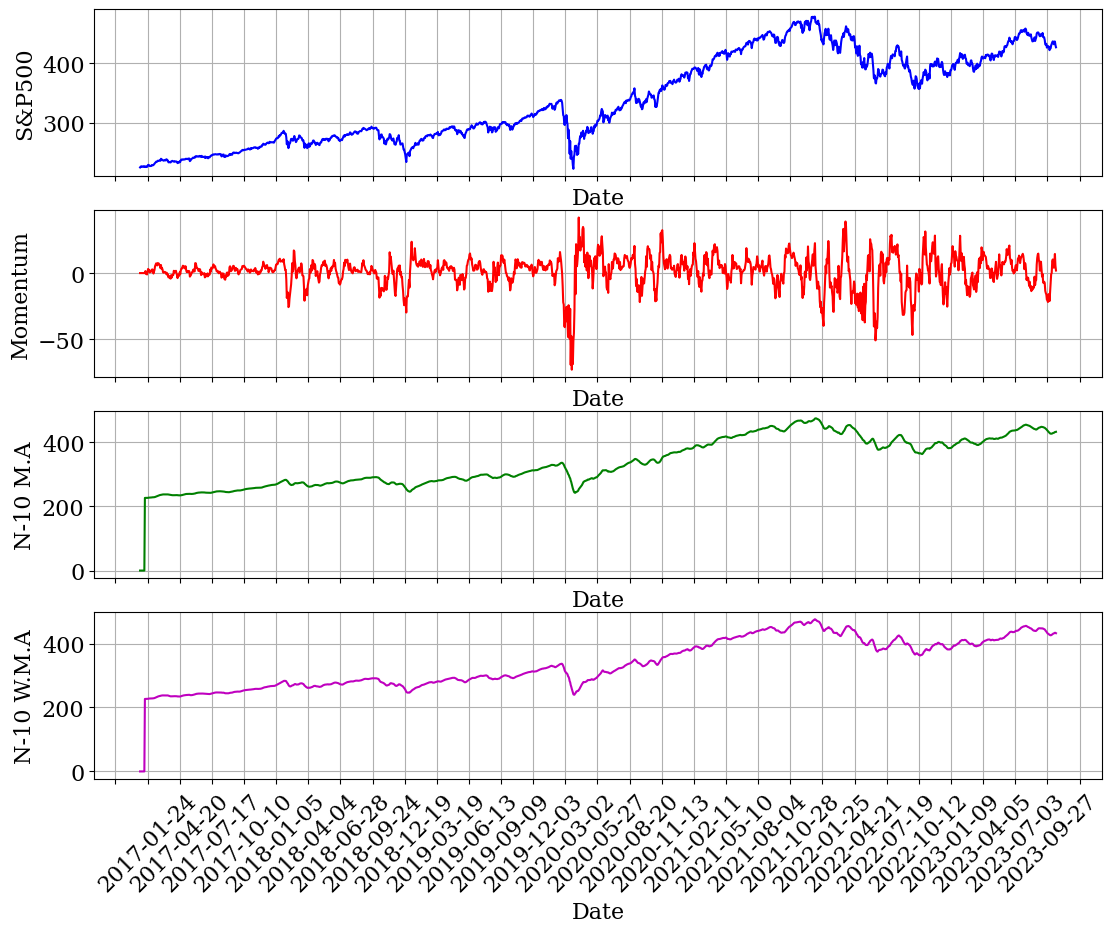

In [45]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, sharex=True,figsize=(13,10))

ax1.plot(data['date'], data['close'],'b')
ax1.set_xlabel('Date')
ax1.set_ylabel('S&P500')
ax1.xaxis.set_major_locator(DayLocator(interval=x_spacing))
ax1.tick_params(axis='x', rotation=x_rotation)
ax1.grid()


ax2.plot(data['date'], data['momentum'],'r')
ax2.set_xlabel('Date')
ax2.set_ylabel('Momentum')
ax2.tick_params(axis='x', rotation=x_rotation)
ax2.xaxis.set_major_locator(DayLocator(interval=x_spacing))
ax2.grid()

ax3.plot(data['date'], data['n_rolling_mean'],'g')
ax3.set_xlabel('Date')
ax3.set_ylabel('N-10 M.A')
ax3.tick_params(axis='x', rotation=x_rotation)
ax3.xaxis.set_major_locator(DayLocator(interval=x_spacing))
ax3.grid()

ax4.plot(data['date'], data['weighted_rolling_mean'],'m')
ax4.set_xlabel('Date')
ax4.set_ylabel('N-10 W.M.A')
ax4.tick_params(axis='x', rotation=x_rotation)
ax4.xaxis.set_major_locator(DayLocator(interval=x_spacing))
ax4.grid()


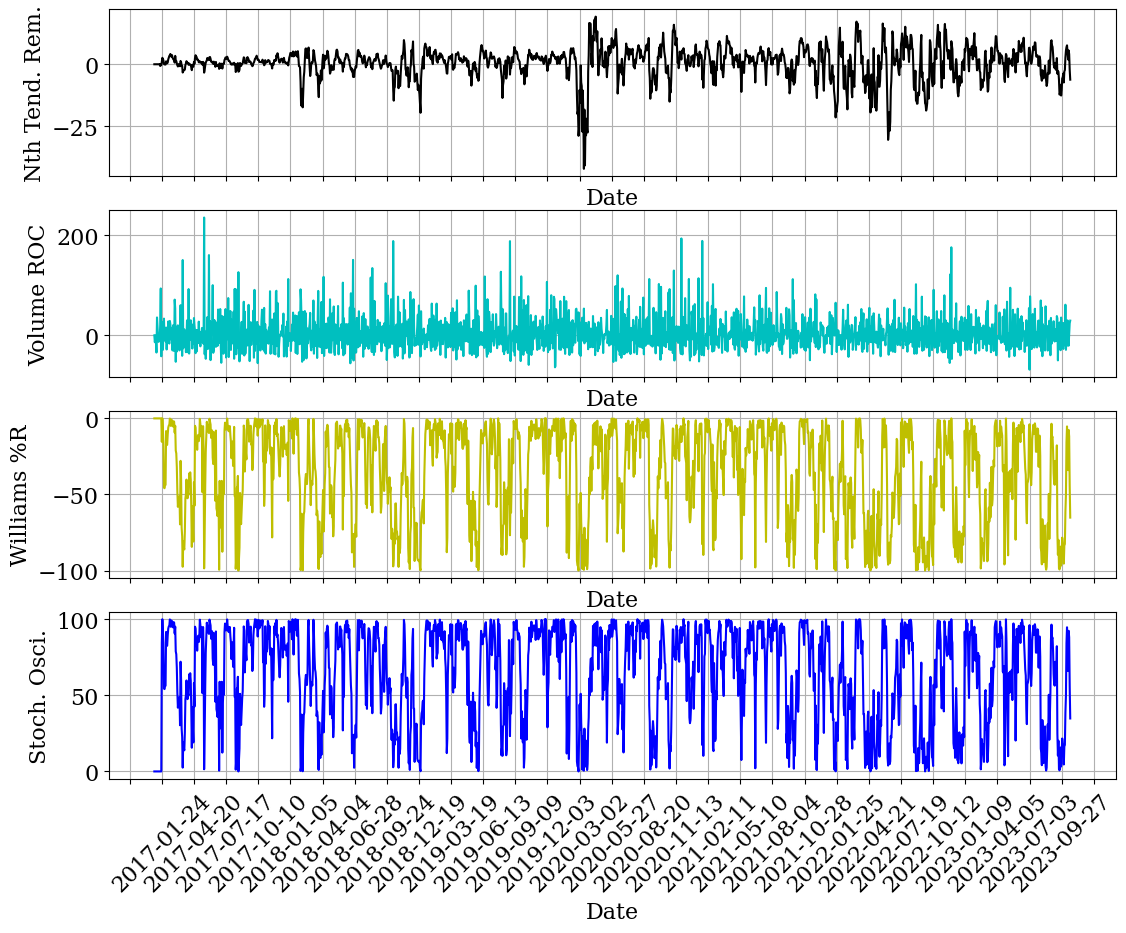

In [46]:
fig, (ax5, ax6, ax7, ax8) = plt.subplots(nrows=4, ncols=1, sharex=True,figsize=(13,10))

ax5.plot(data['date'], data['nday_tendency_removal'],'k')
ax5.set_xlabel('Date')
ax5.set_ylabel('Nth Tend. Rem.')
ax5.tick_params(axis='x', rotation=x_rotation)
ax5.xaxis.set_major_locator(DayLocator(interval=x_spacing))
ax5.grid()

ax6.plot(data['date'], data['volume_roc'],'c')
ax6.set_xlabel('Date')
ax6.set_ylabel('Volume ROC')
ax6.tick_params(axis='x', rotation=x_rotation)
ax6.xaxis.set_major_locator(DayLocator(interval=x_spacing))
ax6.grid()

ax7.plot(data['date'], data['williams_p_range'],'y')
ax7.set_xlabel('Date')
ax7.set_ylabel('Williams %R')
ax7.tick_params(axis='x', rotation=x_rotation)
ax7.xaxis.set_major_locator(DayLocator(interval=x_spacing))
ax7.grid()

ax8.plot(data['date'], data['stochastic_oscillator'],'b')
ax8.set_xlabel('Date')
ax8.set_ylabel('Stoch. Osci.')
ax8.tick_params(axis='x', rotation=x_rotation)
ax8.xaxis.set_major_locator(DayLocator(interval=x_spacing))
ax8.grid()

In [34]:
# MCT
data['n_highest_high'].describe()

count    1711.000000
mean      344.875319
std        81.218692
min         0.000000
25%       280.410004
50%       327.230011
75%       417.619995
max       479.980011
Name: n_highest_high, dtype: float64